In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from scipy import optimize

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

%matplotlib inline



In [2]:
df = pd.read_csv('2019-ncov.csv',index_col=0)

# filling missing date by taking average of the previous and preceding dates
for country in df.columns:
    df[country]['2020-01-22'] = (df[country]['2020-01-21'] + df[country]['2020-01-23'])/2

df['Total_no_china'] = df.loc[:,df.columns != 'China'].sum(axis=1)
df['Total'] = df.loc[:,df.columns != 'Total_no_china'].sum(axis=1)


In [3]:
#guassian function
def fx(x, a,b,c):
    return a*np.exp(-(x-b)**2/(2*(c**2)))

# def func(x, w0, w1, w2):
#     y = w0 + w1*x + w2*x
#     return np.exp(y)/((1+np.exp(y))**2)

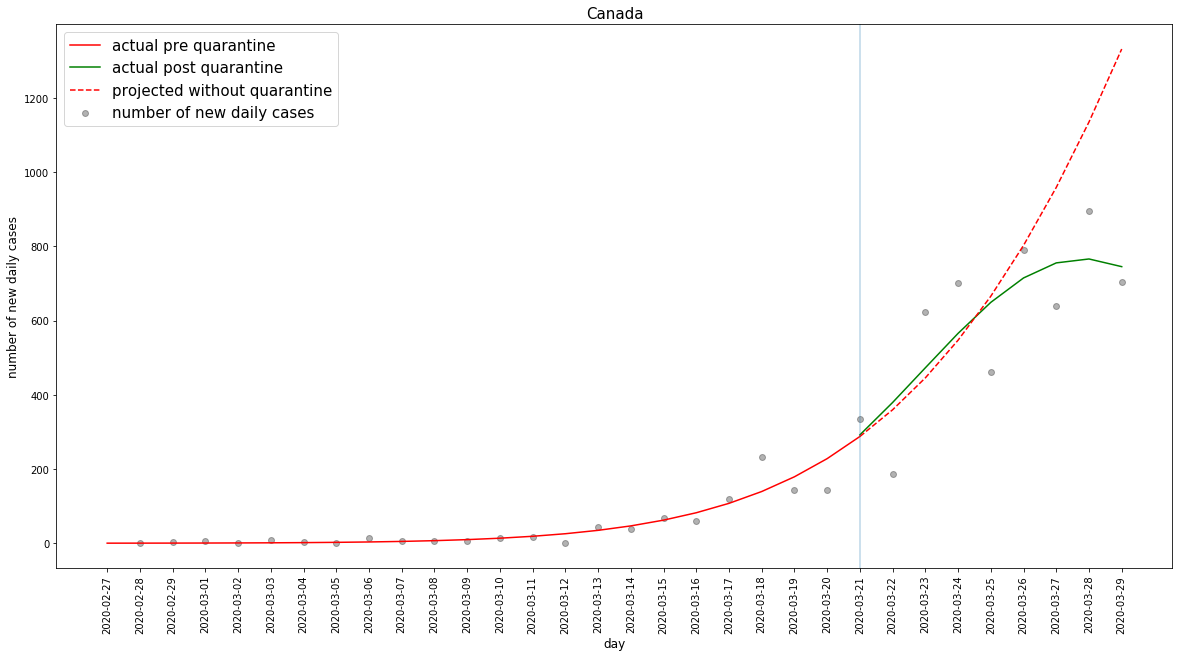

In [8]:
# interrupted time series regression

country = 'Canada'

df_part = pd.DataFrame(df[country])
df_part = df_part.loc[df_part[country]>10] #checks for at least 10 cases
df_part.index = df_part.index.set_names(['date'])
df_part.reset_index(inplace=True)

# taking derivative
df_part['d1'] = df_part[country].diff()

int_date_indx = -9

X0 = np.array(df_part.index)

# pre intervention regression
dd1 = df_part.dropna()
dd1 = dd1.iloc[:int_date_indx+1]
X = np.array(dd1.index)
y = np.array(dd1['d1'])
bounds = ([50,15,0],[5000,90,20])
pre_params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
reg = pd.DataFrame(fx(X0,*pre_params),index=X0)
reg.rename(columns = {0:'pre_reg'}, inplace=True)
df_part = df_part.merge(reg, how='outer',left_index=True, right_index=True)
# print(params)


# post intervention regression
dd1 = df_part[['date', 'd1']].dropna()
dd1 = dd1.iloc[int_date_indx:]
X = np.array(dd1.index)
y = np.array(dd1['d1'])
bounds = ([50,15,0],[5000,90,20])
post_params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
reg = pd.DataFrame(fx(X,*post_params),index=X)
reg.rename(columns = {0:'post_reg'}, inplace=True)
df_part = df_part.merge(reg, how='outer',left_index=True, right_index=True)

# print(params)

# df_part

data1 = [df_part['date'],df_part['d1']]
data2 = [df_part['pre_reg'].loc[df_part['pre_reg'].index[:int_date_indx+1]]]
data3 = [df_part['post_reg']]
data4 = [df_part['pre_reg'].loc[df_part['pre_reg'].index[int_date_indx:]]]



color='k'
fig, ax1 = plt.subplots(facecolor='w', figsize=(20,10))
ax1.set_title(country, fontsize=15)
ax1.set_xlabel('day', fontsize=12)
ax1.set_ylabel('number of new daily cases', color=color, fontsize=12)
ax1.scatter(*data1, color='k', alpha = 0.3, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)

ax1.plot(*data2, color='r', alpha = 1, label='actual pre quarantine')
ax1.plot(*data3, color='g', alpha = 1, label='actual post quarantine')
ax1.plot(*data4, color='r', alpha = 1, label='projected without quarantine', linestyle='dashed')

ax1.axvline(x=df_part.index[int_date_indx], alpha=0.3)

plt.legend(prop={'size': 15})

plt.show()

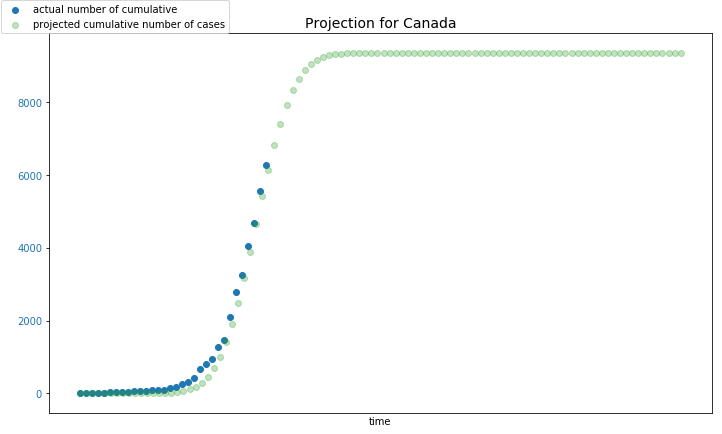

estimated total after 100 days: 9,359


In [11]:
# Projections
df_part = df[country]
df_part = df_part.loc[df_part>10] #checks for at least 10 cases

# taking derivative
d1 = df_part.diff()

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)



# regression
bounds = ([50,15,0],[5000,90,20])
params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
# print(params)

days = 100
t = np.linspace(0,days,days)

y1 = fx(t,*post_params)
# y1 = fx(t,*pre_params)
red = [df_part.index, df_part]
blue = [t, np.cumsum(y1)]



fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Projection for {}'.format(country), fontsize=14)

color = 'tab:blue'
ax1.set_xlabel('time')
# ax1.set_ylabel('actual number of cumulative', color=color)
ax1.scatter(*red, color=color, alpha = 1, label='actual number of cumulative')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
# ax1.set_ylabel('projected cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax1.scatter(*blue, color=color, alpha=0.3, label = 'projected cumulative number of cases')
# ax2.tick_params(axis='y', labelcolor=color)

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)

# ax1.plot(fx(X,*params), c='r')

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('./figures/figure10.png', dpi=300)


plt.show()

print('estimated total after {0} days: {1:,}'.format(days,int(np.cumsum(y1)[-1])))

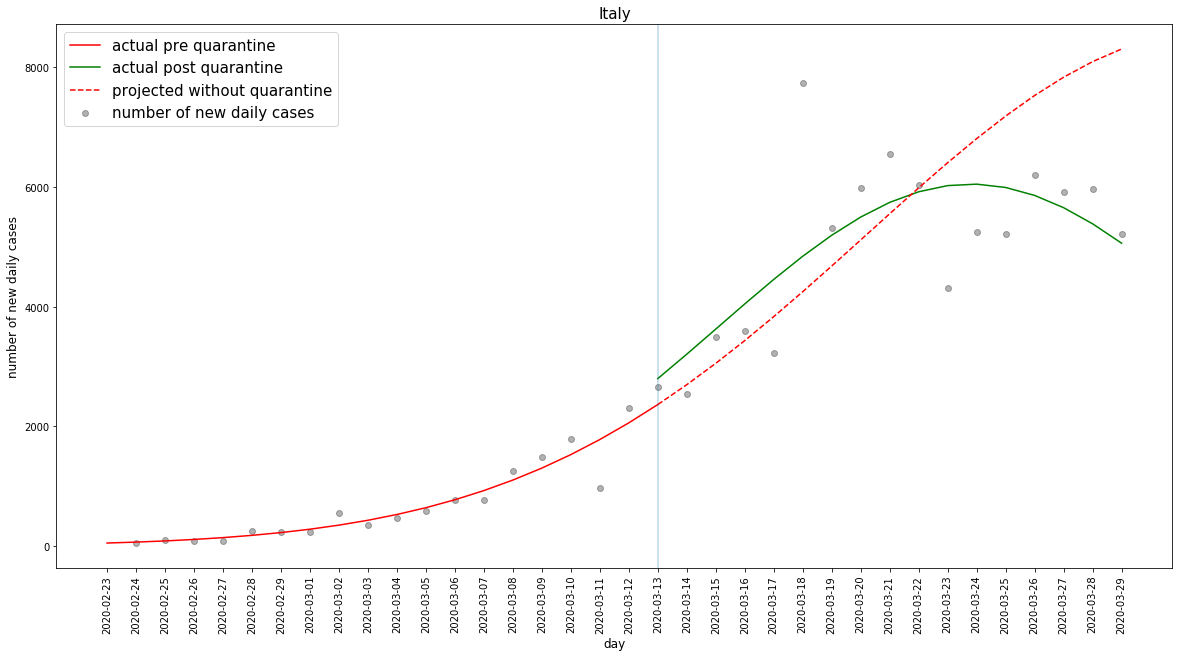

In [6]:
# interrupted time series regression

country = 'Italy'

df_part = pd.DataFrame(df[country])
df_part = df_part.loc[df_part[country]>10] #checks for at least 10 cases
df_part.index = df_part.index.set_names(['date'])
df_part.reset_index(inplace=True)

# taking derivative
df_part['d1'] = df_part[country].diff()

int_date_indx = -17

X0 = np.array(df_part.index)

# pre intervention regression
dd1 = df_part.dropna()
dd1 = dd1.iloc[:int_date_indx+2]
X = np.array(dd1.index)
y = np.array(dd1['d1'])
bounds = ([50,15,0],[10000,90,20])
pre_params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
reg = pd.DataFrame(fx(X0,*pre_params),index=X0)
reg.rename(columns = {0:'pre_reg'}, inplace=True)
df_part = df_part.merge(reg, how='outer',left_index=True, right_index=True)
# print(params)


# post intervention regression
dd1 = df_part[['date', 'd1']].dropna()
dd1 = dd1.iloc[int_date_indx:]
X = np.array(dd1.index)
y = np.array(dd1['d1'])
bounds = ([50,15,0],[10000,90,20])
post_params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
reg = pd.DataFrame(fx(X,*post_params),index=X)
reg.rename(columns = {0:'post_reg'}, inplace=True)
df_part = df_part.merge(reg, how='outer',left_index=True, right_index=True)

# print(params)

# df_part

data1 = [df_part['date'],df_part['d1']]
data2 = [df_part['pre_reg'].loc[df_part['pre_reg'].index[:int_date_indx+1]]]
data3 = [df_part['post_reg']]
data4 = [df_part['pre_reg'].loc[df_part['pre_reg'].index[int_date_indx:]]]



color='k'
fig, ax1 = plt.subplots(facecolor='w', figsize=(20,10))
ax1.set_title(country, fontsize=15)
ax1.set_xlabel('day', fontsize=12)
ax1.set_ylabel('number of new daily cases', color=color, fontsize=12)
ax1.scatter(*data1, color='k', alpha = 0.3, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)

ax1.plot(*data2, color='r', alpha = 1, label='actual pre quarantine')
ax1.plot(*data3, color='g', alpha = 1, label='actual post quarantine')
ax1.plot(*data4, color='r', alpha = 1, label='projected without quarantine', linestyle='dashed')

ax1.axvline(x=df_part.index[int_date_indx], alpha=0.3)

plt.legend(prop={'size': 15})

plt.show()